In [1]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.0001
EPOCHS = 100
EVALUATION_DELAY = 10
print(DEVICE)

cuda


In [3]:
with open("../../data/custom_fragments_30/embeddings/final_embeddings_train.pkl", "rb") as f:
    train_embeddings = pickle.load(f)

In [4]:
with open("../../data/custom_fragments_30/embeddings/final_embeddings_val.pkl", "rb") as f:
    val_embeddings = pickle.load(f)

In [5]:
train_embeddings[0]

('A9MH08',
 False,
 'complete',
 tensor([ 0.0270,  0.0671, -0.0068,  ..., -0.0022, -0.0519,  0.0330]))

In [6]:
len(train_embeddings)

93626

In [7]:
len(val_embeddings)

21391

In [12]:
class RandomDataset(Dataset):
    def __init__(self, embeddings):
        self.labels = []
        self.embeddings = []

        for elem in embeddings:
            self.labels.append(torch.tensor([elem[1]], dtype=torch.float32))
            self.embeddings.append(elem[3])

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [13]:
train_dataset = RandomDataset(train_embeddings)

In [14]:
val_dataset = RandomDataset(val_embeddings)

In [15]:
train_dataset[0]

(tensor([ 0.0270,  0.0671, -0.0068,  ..., -0.0022, -0.0519,  0.0330]),
 tensor([0.]))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [17]:
class RandomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [18]:
model1 = RandomModel()
model1.to(DEVICE)

RandomModel(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)

In [20]:
def train_binary(dataloader, model, optimizer, loss_fn, device: str):
    model.train()
    total_loss = 0.0
    total_samples = 0
    total_correct = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = torch.sigmoid(logits)
            predicted_labels = (preds >= 0.5).float()
            total_correct += (predicted_labels == y).sum().item()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [21]:
def evaluate_binary(dataloader, model, loss_fn, device: str):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    total_correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            loss = loss_fn(logits, y)

            preds = torch.sigmoid(logits)
            predicted_labels = (preds >= 0.5).float()

            total_correct += (predicted_labels == y).sum().item()

            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [22]:
prev_loss = 10000

In [23]:
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
start = 0

In [24]:
start_time = time.time()
for i in range(start, EPOCHS + start):
    print(f"Epoch: {i}")

    train_loss, train_accuracy = train_binary(train_loader, model1, optimizer, loss_fn, DEVICE)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Training: Avg_Loss: {train_loss:.8f}; Accuracy: {train_accuracy:.8f}")

    if i % EVALUATION_DELAY == 0:
        eval_loss, eval_accuracy = evaluate_binary(val_loader, model1, loss_fn, DEVICE)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        print(f"Validation: Avg_Loss: {eval_loss:.8f}; Accuracy: {eval_accuracy:.8f}")

        if eval_loss < prev_loss:
            torch.save(model1.state_dict(), f"./model_saves2/random_model_epoch_{i}.pt")
            print(f"\033[92mSaved Model at epoch {i}\033[m")

            prev_loss = eval_loss

print(f"\033[92mTraining complete; took: {time.time() - start_time:.2f} seconds; avg: {(time.time() - start_time) / EPOCHS:.2f} seconds/epoch; best: {prev_loss}\033[0m")

Epoch: 0
Training: Avg_Loss: 0.25034338; Accuracy: 0.90422532
Validation: Avg_Loss: 0.19053688; Accuracy: 0.92468795
Saved Model at epoch 0
Epoch: 1
Training: Avg_Loss: 0.17973302; Accuracy: 0.92821438
Epoch: 2
Training: Avg_Loss: 0.16364419; Accuracy: 0.93568026
Epoch: 3
Training: Avg_Loss: 0.15160635; Accuracy: 0.94029436
Epoch: 4
Training: Avg_Loss: 0.14128778; Accuracy: 0.94523957
Epoch: 5
Training: Avg_Loss: 0.13225571; Accuracy: 0.94938372
Epoch: 6
Training: Avg_Loss: 0.12430461; Accuracy: 0.95217141
Epoch: 7
Training: Avg_Loss: 0.11632671; Accuracy: 0.95516203
Epoch: 8
Training: Avg_Loss: 0.10875586; Accuracy: 0.95856920
Epoch: 9
Training: Avg_Loss: 0.10105556; Accuracy: 0.96112191
Epoch: 10
Training: Avg_Loss: 0.09391656; Accuracy: 0.96357849
Validation: Avg_Loss: 0.15689065; Accuracy: 0.94291992
Saved Model at epoch 10
Epoch: 11
Training: Avg_Loss: 0.08684976; Accuracy: 0.96674001
Epoch: 12
Training: Avg_Loss: 0.08006248; Accuracy: 0.96938884
Epoch: 13
Training: Avg_Loss: 0.07

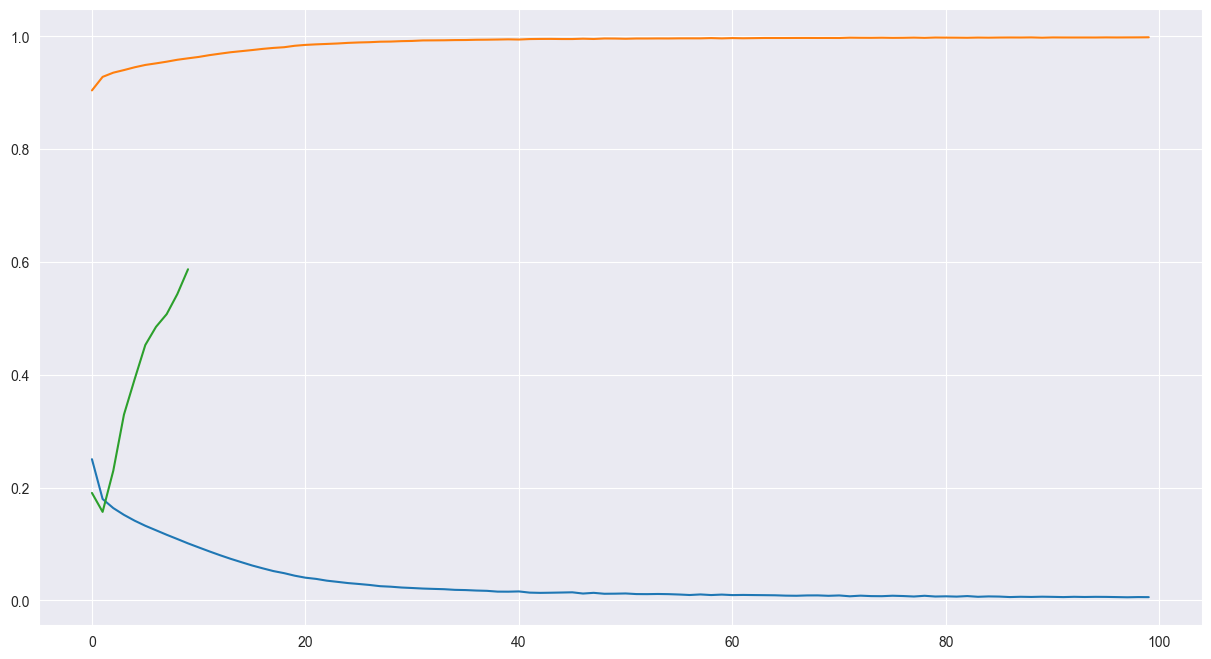

In [25]:
plt.figure(figsize=(15, 8))

plt.plot(train_losses)
plt.plot(train_accuracies)
plt.plot(eval_losses)
plt.show()

In [104]:
fragment_counts = sum([label == 1 for embedding, label in train_dataset])
fragment_counts

tensor([228382])

In [105]:
non_fragment_counts = sum([label != 1 for embedding, label in train_dataset])
non_fragment_counts

tensor([222840])

In [106]:
fragment_counts / non_fragment_counts

tensor([1.0249])

In [108]:
fragment_counts / (non_fragment_counts + fragment_counts)

tensor([0.5061])

In [109]:
torch.save(model1.state_dict(), "./model_saves2/final_model.pt")

In [7]:
with open("../../experiments/true_fragment_embeddings/final_embeddings.pkl", "rb") as p:
    true_fragment_embeddings = pickle.load(p)

true_fragment_dataset = RandomDataset(true_fragment_embeddings)

In [8]:
true_fragment_embeddings[0]

('A0A068B6Q6',
 True,
 tensor([ 0.0404,  0.0715, -0.0392,  ...,  0.0468, -0.0203, -0.0079]))

In [9]:
true_fragment_loader = DataLoader(true_fragment_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [11]:
model1.load_state_dict(torch.load("./model_saves2/random_model_epoch_10.pt"))

<All keys matched successfully>

In [15]:
test_loss, test_accuracy = evaluate_binary(true_fragment_loader, model1, loss_fn, DEVICE)

In [16]:
test_loss

0.5701013821006032

In [17]:
test_accuracy

0.8369541121702505

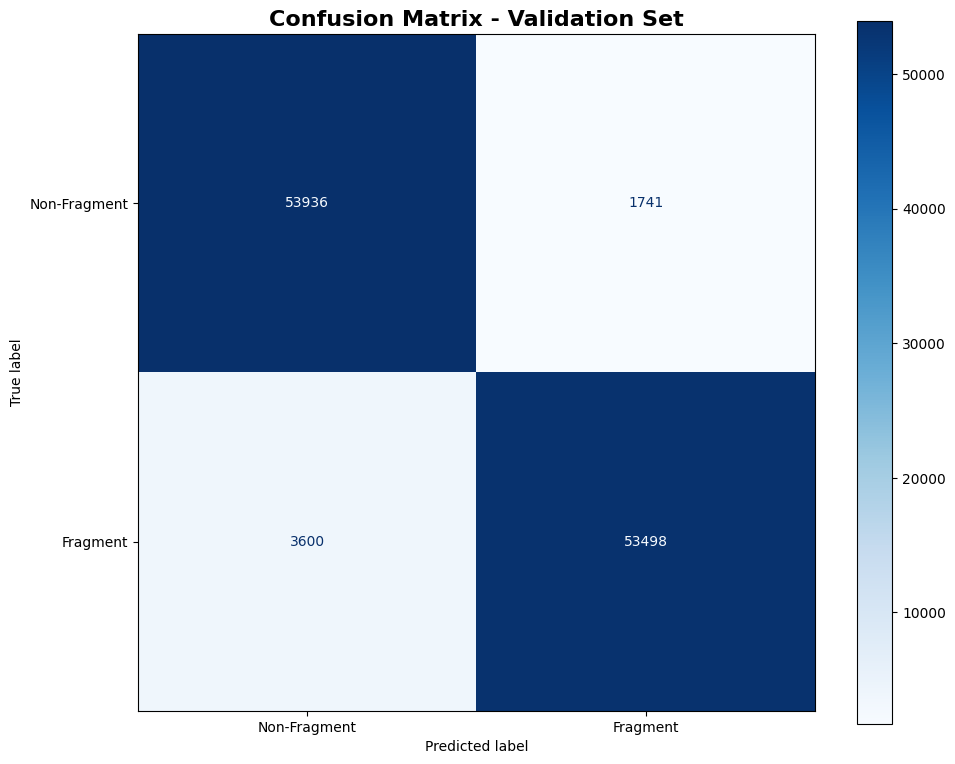

In [31]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Non-Fragment', 'Fragment'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [30]:
# Calculate metrics for both classes
precision = precision_score(y_true_val, y_pred_val, average=None)
recall = recall_score(y_true_val, y_pred_val, average=None)
f1 = f1_score(y_true_val, y_pred_val, average=None)

print("\nMetrics by Class:")
print(f"Class 0 (Non-Fragment) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 (Fragment)     - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

# Calculate macro and weighted averages
precision_macro = precision_score(y_true_val, y_pred_val, average='macro')
recall_macro = recall_score(y_true_val, y_pred_val, average='macro')
f1_macro = f1_score(y_true_val, y_pred_val, average='macro')

precision_weighted = precision_score(y_true_val, y_pred_val, average='weighted')
recall_weighted = recall_score(y_true_val, y_pred_val, average='weighted')
f1_weighted = f1_score(y_true_val, y_pred_val, average='weighted')

print("\nMacro Average:")
print(f"Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
print("\nWeighted Average:")
print(f"Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")


Metrics by Class:
Class 0 (Non-Fragment) - Precision: 0.9374, Recall: 0.9687, F1: 0.9528
Class 1 (Fragment)     - Precision: 0.9685, Recall: 0.9370, F1: 0.9525

Macro Average:
Precision: 0.9530, Recall: 0.9528, F1: 0.9526

Weighted Average:
Precision: 0.9532, Recall: 0.9526, F1: 0.9526


In [29]:
# Calculate confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)
print("Confusion Matrix (Validation Set):")
print(cm_val)

Confusion Matrix (Validation Set):
[[53936  1741]
 [ 3600 53498]]


In [28]:
# Get predictions on validation set
y_true_val, y_pred_val = get_predictions(val_loader_eval, model1, DEVICE)

In [27]:
# Create a fresh validation loader without shuffling for consistent predictions
val_loader_eval = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [20]:
# Get predictions for validation dataset
def get_predictions(dataloader, model, device: str):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).float()
            
            logits = model(x)
            preds = torch.sigmoid(logits)
            predicted_labels = (preds >= 0.5).float()
            
            all_predictions.extend(predicted_labels.cpu().numpy().flatten())
            all_labels.extend(y.cpu().numpy().flatten())
    
    return np.array(all_labels), np.array(all_predictions)

In [19]:
# Import sklearn metrics for confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np